In [1]:
# %reset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math
import datetime 
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy.stats import describe
from scipy import stats
from pylab import plt, mpl
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
import random
from arch import arch_model
import matrix_optimize
from matrix_optimize import port_ret, port_vol, min_vol, eff_vol, sharpe_ratio, efficient_frontier, tangent_portfolio, portfolio_selection

In [2]:
plt.style.use('seaborn')

In [4]:
mydict = {'IGF': 'Global Infrastructure', 
          'IFGL':'International Developed Real Estate ETF',
          'IXN': 'iShares Global Tech ETF',
          'IXJ': 'iShares Global Healthcare ETF',
          'VDE': 'Vanguard Energy ETF',
          'KXI': 'iShares Global Consumer Staples ETF',
          'SPGP':'iShares Gold Producers UCITS ETF',
          'VIS': 'Vanguard Industrial ETF',
          'RXI': 'iShares Global Consumer Discretionary ETF'
         }
# List shares of interest as Yahoo Fiance "Ticker"/"Symbol"
mylist = list(mydict)[:]
noa = len(mylist)

# Load Data
rets = pd.read_excel(r'C:\Users\Ma-Bi\OneDrive\Kandidat\Topics in Financial Econometrics - Seminar\log_rets.xlsx', 
                   sheet_name='Sheet', index=True, index_col=[0])

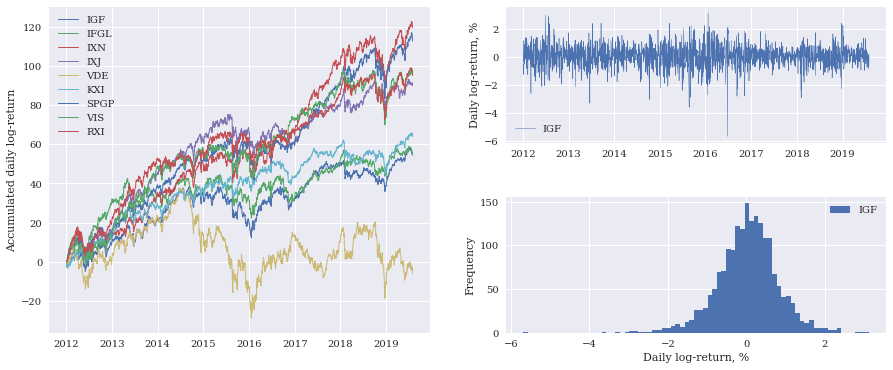

In [6]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

mpl.rcParams['font.family'] = 'serif'
#%matplotlib inline

plt.subplot(1, 2, 1)
plt.plot(rets.cumsum(), lw=1.0)
plt.ylabel('Accumulated daily log-return')
plt.legend(list(mydict))

plt.subplot(2, 2, 2)
plt.plot(rets['IGF'], lw=0.5, label='IGF')
plt.legend()
#plt.plot(rets.iloc[:, 0:5], lw=0.2)
plt.ylabel('Daily log-return, %')
#plt.legend(list(mydict)[0:5])


plt.subplot(2, 2, 4)
plt.hist(rets['IGF'], bins=75, label='IGF')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Daily log-return, %')
#plt.plot(rets.iloc[:, 5:], lw=0.2)
#plt.ylabel('Daily log-return, %')
#plt.legend(list(mydict)[5:])

#plt.show()
plt.savefig('historic_development.png', dpi=300, bbox_inches='tight')

In [97]:
# Need in and out of sample for other purposes
n_time = 50
n_test = 21
H = -n_time+n_test

train, test = rets[:-n_time], rets[-n_time : H]

# Traditional Markowitch


In [98]:
df,w_min, ret_min, vol_min, SR_min, w_eff, ret_eff, vol_eff, SR_eff, w_tan, ret_tan, vol_tan, SR_tan, evols, erets,front_vol, front_ret, opt = portfolio_selection(
                                                                  mu=train.mean(), 
                                                                  omega=train.cov(), 
                                                                  noa=noa,  
                                                                  mylist=mylist,
                                                                  target_return=30/252)
trad_w = w_tan
trad_w

Optimal parameter values =  [ 0.      1.3628 17.1641]
Check that eq holds: [ 0.  0. -0.]


array([ 0.25420603, -0.21166332,  0.22850251,  0.21590452, -0.76903015,
        0.06374372,  0.5830804 ,  0.5338794 ,  0.10175377])

## Moving on to GARCH modelleing

In [99]:
parameters = np.zeros((noa,5))                         # 4 for GARCH(1,1) and 5 for GJR-GARCH(1,1)
p_values = np.zeros((noa,5))
std_error = np.zeros((noa,5))
std_resid = np.zeros((noa,len(train[mylist[0]])))
estimation_result = []



for i,n in enumerate(mylist):
    # split into train/test = in-sample/out-of-sample
    # train, test = rets[n][:-n_time], rets[n][-n_time : H] 

    # define GARCH model
    # model = arch_model(train, mean='Constant', vol='GARCH', p=1, q=1)
    model = arch_model(train[n], p=1, o=1, q=1)          # GJR Garch - just change parameters to 5 instead of 4

    # fit model
    res = model.fit(disp='off')
    estimation_result.append(res)

    # Save parameter estimates
    parameters[i][:] = res.params[:]
    p_values[i][:] = res.pvalues[:]
    std_error[i][:] = res.std_err[:]
    
    # Save standardized residuals
    std_resid[i][:] = res.resid / res.conditional_volatility
    
df_std_resid = pd.DataFrame(std_resid).T

In [100]:
# Normality test of Standardized residuals:
JB = []

for i in range(len(mylist)):
    JB.append(stats.jarque_bera(std_resid[i]))
    
JB
# Nul hypothesis rejected on a 5% significance level. Thus not Normal as hoped by GJR...

[(191.15689819982398, 0.0),
 (281.2727116018766, 0.0),
 (366.366073780259, 0.0),
 (131.315438569928, 0.0),
 (136.90777433219463, 0.0),
 (188.99245785125024, 0.0),
 (279.8323103176314, 0.0),
 (351.40989544288703, 0.0),
 (657.5958337319582, 0.0)]

In [101]:
param_est = pd.DataFrame(parameters, columns=['mu', 'omega', 'alpha','gamma', 'beta'])
param_est.index  = mylist
param_est = param_est.round(3).T
param_est

,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI
mu,0.027,0.028,0.062,0.043,0.001,0.029,0.052,0.039,0.047
omega,0.036,0.020,0.055,0.036,0.022,0.035,0.036,0.044,0.038
alpha,0.099,0.078,0.000,0.000,0.004,0.045,0.000,0.000,0.039
gamma,0.083,0.074,0.175,0.178,0.078,0.152,0.199,0.145,0.178
beta,0.805,0.861,0.851,0.856,0.942,0.806,0.851,0.874,0.826


## Simulation FHS

\begin{align}
    r_{t} &= \mu + \sigma_{t} z_{t} \\
    \sigma^2_{t} &= \omega + \alpha r_{t-1}^2 + \gamma 1_{r_{t-1}<0}r_{t-1} + \beta \sigma_{t-1}^2  \\
    z &\sim \textit{i.i.d. } \mathcal{N}(0,1)
\end{align}

In [102]:
import math
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

In [103]:
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [104]:
# Filtered Historical Simulation
 
npr.seed(741)
N = n_test # 21

# Create dictionaries
SIM_RET = {}
SIM_SIGMA = {}
ACC_RET = {}
AVG_RET = {}
AVG_VOL = {}

# Loop over assets
for j,x in enumerate(mylist):  #range(noa):

    # Define parameters for the given asset
    param = parameters[j]
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    gamma = param[3]
    beta = param[4]
    acc_ret = []
    avg_ret = [] 
    avg_vol = []
    
    # Define vector for simulated sigma_(t+1) for GARCH(1,1)
    sim_sigma = np.empty(N)
    sim_sigma[0] = ((train[x][-1] - mu)/ std_resid[j][-1])       # sigma_t+1 is predetermined
    
    # Loop for simulations
    for i in range(5000):
        z = random.sample(list(std_resid[j][:]), N)            # Bootstrap random draw from std.res.
        sim_ret = np.empty(N)                                          # Define empty vector for simulated return
        
        # Loop for horizon
        for n in range(N-1):
            sim_ret[n] = mu + sim_sigma[n] * z[n]
            if sim_ret[n]>0:
                sim_sigma[n+1] =  math.sqrt(omega + alpha * sim_ret[n]**2 + beta * sim_sigma[n]**2)
            else:
                sim_sigma[n+1] = math.sqrt(omega + alpha * sim_ret[n]**2 + gamma * sim_ret[n]**2 
                                           + beta * sim_sigma[n]**2)
        
        acc_ret.append(np.sum(sim_ret))                               # all 50.000 accumulated return
        avg_ret.append(np.mean(sim_ret))                              # all 50.000 average return
        avg_vol.append(np.mean(sim_sigma))                            # all 50.000 average sigma 

    ACC_RET["FHS_{0}".format(x)] = acc_ret
    AVG_RET["FHS_{0}".format(x)] = avg_ret
    AVG_VOL["FHS_{0}".format(x)] = avg_vol

In [105]:
# Daily return (average):
FHS_mu = pd.DataFrame.from_dict(AVG_RET).mean()

# Daily vol
FHS_vol = pd.DataFrame.from_dict(AVG_VOL).mean()

# Daily average variance:
FHS_var = FHS_vol**2

Now We have obtained estimates for the 21-period expected return and variance for each asset.

Assuming constant correlation between the assets, we have obtained a new covariance matrix. And expected return, so we can construct a new effecient portfolio. 

In [106]:
FHS_omega = rets.cov()
np.fill_diagonal(FHS_omega.values, FHS_var)
FHS_omega.round(2)

,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI
IGF,0.42,0.52,0.54,0.45,0.67,0.42,0.44,0.51,0.52
IFGL,0.52,0.42,0.57,0.46,0.60,0.42,0.45,0.52,0.56
IXN,0.54,0.57,1.81,0.62,0.77,0.47,0.79,0.76,0.76
IXJ,0.45,0.46,0.62,0.66,0.58,0.42,0.57,0.57,0.57
VDE,0.67,0.60,0.77,0.58,1.43,0.45,0.66,0.83,0.72
KXI,0.42,0.42,0.47,0.42,0.45,0.41,0.40,0.44,0.46
SPGP,0.44,0.45,0.79,0.57,0.66,0.40,1.26,0.66,0.66
VIS,0.51,0.52,0.76,0.57,0.83,0.44,0.66,1.19,0.70
RXI,0.52,0.56,0.76,0.57,0.72,0.46,0.66,0.70,1.09


In [107]:
# All-in-one method
df,w_min, ret_min, vol_min, SR_min, w_eff, ret_eff, vol_eff, SR_eff, w_tan, ret_tan, vol_tan, SR_tan, evols, erets,front_vol, front_ret, opt = matrix_optimize.portfolio_selection(mu=FHS_mu, omega=FHS_omega, noa=noa, mylist=mylist, target_return=30/252)
FHS_w = w_tan

Optimal parameter values =  [ 0.      2.2229 18.7562]
Check that eq holds: [ 0. -0.  0.]


In [108]:
df

,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI,Exp. ret,Exp. vol,SR
Min. vol,0.227000,0.194000,-0.047000,0.011000,-0.105000,0.75200,0.059000,0.002000,-0.093000,12.017203,10.077348,1.192497
Tangent,-3.704467,-3.856503,0.134859,0.963281,0.579452,6.17802,-0.162538,0.160714,0.705528,41.729988,18.772833,2.222892


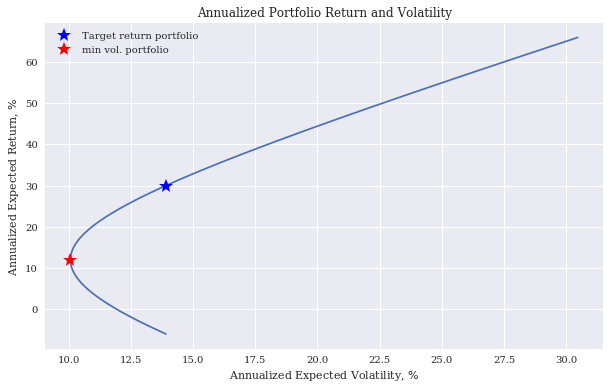

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plt.plot(front_vol, front_ret)

plt.plot(vol_eff, ret_eff, 'b*', markersize=15.0, label='Target return portfolio')
plt.plot(vol_min, ret_min, 'r*', markersize=15.0, label='min vol. portfolio')

    
plt.xlabel('Annualized Expected Volatility, $\%$')
plt.ylabel('Annualized Expected Return, $\%$')
plt.title('Annualized Portfolio Return and Volatility')

plt.legend()
plt.show()

## Tangent Portfolio

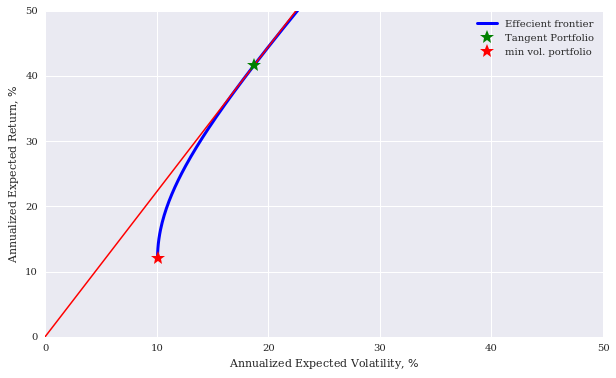

In [110]:
rf=0
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plt.plot(evols, erets, 'b', lw=3.0, label='Effecient frontier')

cx = np.linspace(0.0, 40.0)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)

plt.plot(opt[2], ret_tan, 'g*', markersize=15, label='Tangent Portfolio')
plt.plot(vol_min, ret_min, 'r*', markersize=15.0, label='min vol. portfolio')

# plot individual ETFs
# for i,type in enumerate(FHS_label):
#     x2 = math.sqrt(FHS_var[type]*252)
#     y2 = FHS_mu[type]*252
#     plt.scatter(x2, y2, marker='o')  
#     plt.text(x2+0.05, y2+0.05, type, fontsize=9)


plt.grid(True)
axes = plt.gca()
axes.set_xlim([0,50])
axes.set_ylim([0,50])
plt.xlabel('Annualized Expected Volatility, $\%$')
plt.ylabel('Annualized Expected Return, $\%$')
# plt.title('Annualized Portfolio FHS Return and Volatility')
plt.legend()

plt.savefig('FHS_tangent_port.png', dpi=300, bbox_inches='tight')


# Conclusion

# Backtest

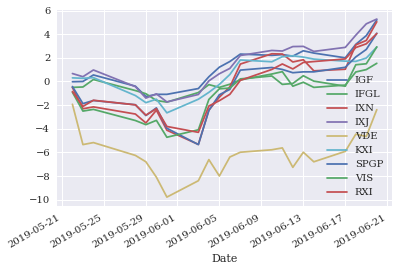

In [111]:
# how the 21 days actually went
test.cumsum().plot()
plt.show()

In [113]:
#Test period accumulated return
hist_perform_ret = trad_w.dot(test.cumsum().iloc[-1])
print('Traditional portfolio acc. return = ',hist_perform_ret) #*1/(n_time/252))

FHS_perform_ret = FHS_w.dot(test.cumsum().iloc[-1])
print('FHS portfolio acc. return = ', FHS_perform_ret) #*1/(n_time/252))

Traditional portfolio acc. return =  9.670193391991816
FHS portfolio acc. return =  -0.2125907801877851


In [114]:
trad_w.dot(test.cov().dot(trad_w))

1.7319697111191217

In [115]:
FHS_w.dot(test.cov().dot(FHS_w))

14.888633761468826